In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
#This section contains all functions used through the pipeline
#Function to obtain points to base calibration on
def calibrate_buff (images, corners = (9, 6)):
    imgpts = [] #define where points are
    objpts = [] #define where the points should be
    nx = corners[0]
    ny = corners[1]
    obj_pts = np.zeros((nx * ny,3),np.float32)
    obj_pts[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    for fname in images:
        img = plt.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None, flags = cv2.CALIB_CB_NORMALIZE_IMAGE+cv2.CALIB_CB_ADAPTIVE_THRESH)
        if ret:
            imgpts.append(corners)
            objpts.append(obj_pts)
            result = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(result)
    shape = img.shape[1::-1]
    return imgpts, objpts, shape

#Function to calibrate camera
def calibrate (shape, imgpts, objpts):
    ret, mat, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, shape, None, None)
    return mat, dist

#Function to correct camera distortion
def undistort(image, mtx, dist):
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    return undistort

#To obtain the gradient of the image
def color_grad(img, sx_thresh = (30,100), s_thresh=(90,255), k = 3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Using Sobelxy to get a gradient of the image
    sobelxy = cv2.Sobel (gray, cv2.CV_64F,1,1,ksize =k)
    abs_xy = np.absolute(sobelxy)
    scaled = np.uint8(255 * abs_xy/np.max(abs_xy))
    sx_bin = np.zeros_like(scaled)
    sx_bin[(scaled>sx_thresh[0]) & (scaled<sx_thresh[1])] = 1
    
    #Using s channel from hls for picking lines irrespective of light
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = img_hls[:,:,2]
    l_channel = img_hls[:,:,1]
    s_bin = np.zeros_like(s_channel)
    s_bin[(s_channel>s_thresh[0]) & (s_channel<=s_thresh[1])] = 1
    
    #Using the l channel to ignore shadows as lines
    l_bin = np.zeros_like(l_channel)
    l_bin[(l_channel>150)]= 1
    
    binary_image = np.zeros_like(scaled)
    binary_image[(sx_bin==1)|((s_bin==1)&(l_bin==1))] = 1
    return binary_image

#Function to transform image based on transformation matrix
def perspective(img, M):
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped 

def lane_find(binary_warped):
    plt.clf()
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))   

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #Calculate the radius and midpoint
    rad, mid = calc_curve(ploty, left_fitx, right_fitx, midpoint)
    global ploty_prev, left_fitx_prev, right_fitx_prev, rad_prev
    return out_img, ploty, left_fitx, right_fitx, rad, mid

#Function to plot the lanes
def visualise (out_img, ploty, left_fitx, right_fitx):
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return out_img

def draw_region(undist, ploty, left_fitx, right_fitx, Minv, shape, rad, pos):
    #Clear plot
    plt.clf()
    
    #Create a blank image to draw upon
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, shape) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #Print information on the video
    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result,'Radius of curvature : '+str(rad)+'m',(20,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    if pos<0:
        side = 'left'
        pos *= -1
    else:
        side = 'right'
        
    #The final resultant image
    result = cv2.putText(result,'The car is '+str(pos)+'m '+side+' of center',(20,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return result

def calc_curve(ploty, left_fitx, right_fitx, midpoint):    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])   
    #To calculate the position of the car
    mid = 640
    l_mean = left_fitx[-1]
    r_mean = right_fitx[-1]
    avg_curverad = ((left_curverad + right_curverad)/2) - (l_mean*xm_per_pix)
    pos = mid - (r_mean + l_mean)/2 
    return avg_curverad, pos * xm_per_pix

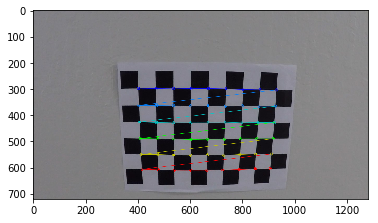

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')
imgpts, objpts, shape = calibrate_buff (images, (9, 6))
mtx, dist = calibrate(shape, imgpts, objpts)

In [4]:
#Source and destination points for matrix transformation
src = np.float32([[560,460],[100,700],[740,460],[1120,700]])
dst = np.float32([[120,0],[80,700],[980,0],[1100,700]])
#Get transformation matrix
M = cv2.getPerspectiveTransform(src, dst)
#Get inverse transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src)

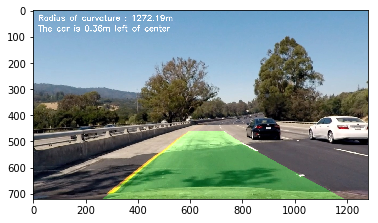

In [5]:
test_images = os.listdir('test_images')
for fname in test_images:
    img = plt.imread('test_images/'+fname)
    dst = undistort(img, mtx, dist)
    warped = color_grad (dst,sx_thresh=(30,100),s_thresh=(150,255),k=5)
    perspect = perspective(warped,M)
    out_image, ploty, left_fitx, right_fitx, rad, mid = lane_find(perspect)

    out_image = visualise(out_image, ploty, left_fitx, right_fitx)
    rad = float("{0:.2f}".format(rad))
    mid = float("{0:.2f}".format(mid))
    result = draw_region(dst, ploty, left_fitx, right_fitx, Minv, shape, rad, mid)
    plt.imshow(result)

In [6]:
#The final pipeline for processing the video
def find_lines(image):
    undist = undistort(image, mtx, dist)
    warped = color_grad (undist,sx_thresh=(30,100),s_thresh=(150,255),k=5)
    perspect = perspective(warped,M)
    out_image, ploty, left_fitx, right_fitx, rad, mid = lane_find(perspect)
    out_image = visualise(out_image, ploty, left_fitx, right_fitx)
    rad =  float("{0:.2f}".format(rad))
    mid =  float("{0:.2f}".format(mid))
    ploty_prev, left_fitx_prev, right_fitx_prev, mid_prev =  ploty, left_fitx, right_fitx, mid
    result = draw_region(undist, ploty, left_fitx, right_fitx, Minv, shape, rad, mid)
    return result

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
video_output = 'Project_video_out1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,30)
white_clip = clip1.fl_image(find_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video Project_video_out1.mp4
[MoviePy] Writing video Project_video_out1.mp4


100%|█████████▉| 1260/1261 [08:19<00:00,  2.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_video_out1.mp4 

CPU times: user 8min 9s, sys: 22 s, total: 8min 31s
Wall time: 8min 23s
